# Data preparation and cleaning
Before we work with the data and use it to train a model, we need to prepare it. This includes cleaning the data, transforming it into a format that is suitable for training a model, and splitting it into a training and test set. In this notebook, we will perform the following steps:
- Analyze the scraped dataset (class distribution)
- Use Canny edge detection to extract ROI from the images
- Crop the images to a fixed size including the ROI
- Perform data augmentation
- Construct datasets for training and testing

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import numpy as np

from skimage import transform
import concurrent.futures as cf
from tqdm import tqdm
import shutil
executor = cf.ThreadPoolExecutor(max_workers=8)

C:\Users\david\AppData\Local\Temp\ipykernel_16568\837438000.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [4]:
gem_count = []
for gem in os.listdir('../dat/images'):
    count = len(os.listdir('../dat/images/' + gem))
    gem_count += [{'gem': gem, 'count': count}]
gem_count = pd.DataFrame(gem_count)
gem_count.sort_values(by='count', ascending=True, inplace=True)
number_of_images = gem_count['count'].sum()

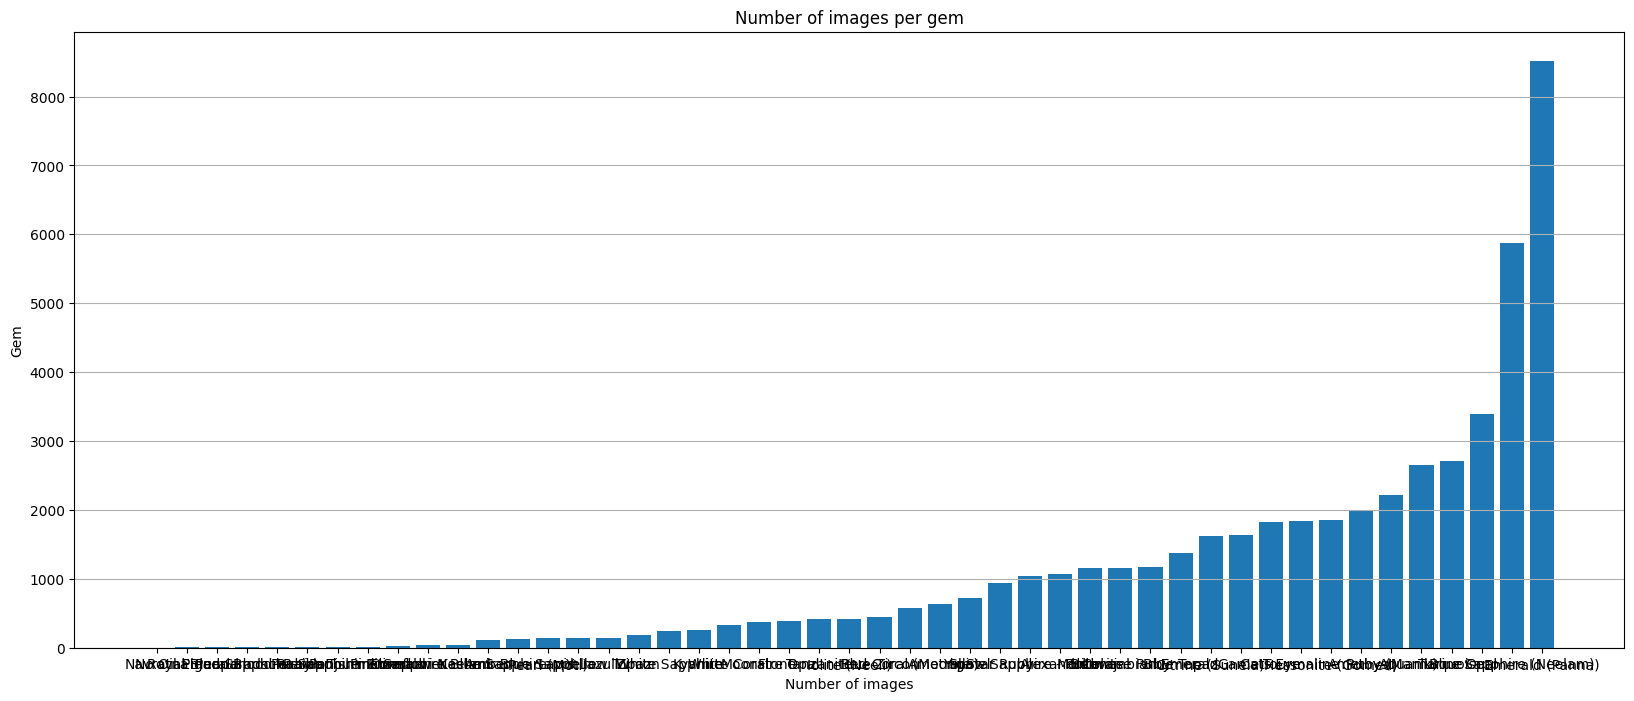

In [5]:
plt.figure(figsize=(20, 8))
plt.bar(gem_count['gem'], gem_count['count'])
plt.title('Number of images per gem')
plt.xlabel('Number of images')
plt.ylabel('Gem')
plt.grid(axis='y')
plt.show()

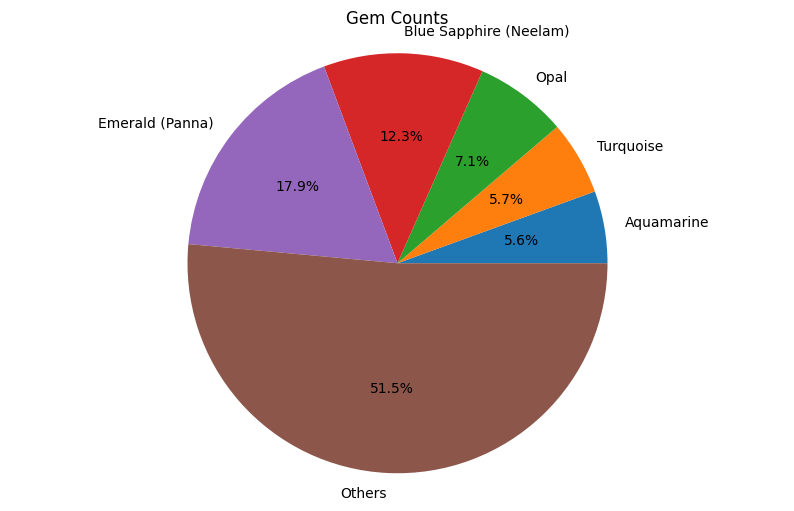

In [48]:
number_of_classes = 6

top = gem_count.tail(number_of_classes-1)
others_count = gem_count['count'].head(gem_count.shape[0] - number_of_classes).sum()
others_row = pd.DataFrame({'gem': ['Others'], 'count': [others_count]})
df = pd.concat([top, others_row], ignore_index=True)

plt.figure(figsize=(10,  6))  # Optional: set the figure size
plt.pie(df['count'], labels=df['gem'], autopct='%1.1f%%')
plt.title('Gem Counts')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

We can see that the distribution of the classes is not balanced.
X classes make up for 2/3 of the total images, while the remaining 1/3 is distributed among the other X of classes.

This is a common problem in machine learning and can lead to a biased model. We will address this issue by using data augmentation to create additional training samples for the minority classes.

### Crop images using Canny edge detection

To extract the region of interest (ROI) from the images, we will use the Canny edge detection algorithm.
This ensures that the model focuses on the relevant part of the image and ignores the background.

The image is then cropped to a fixed size, including the ROI.
By doing this, we can ensure that the model receives consistent input data with maximum relevant information.

In [49]:
def edge_and_cut(img):
    try:
        #gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        #blur = cv2.GaussianBlur(gray, (2,2), 0)
        edges = cv2.Canny(img, img_w, img_h)            
        
        if(np.count_nonzero(edges)>edges.size/10000):
            pts = np.argwhere(edges>0)
            y1,x1 = pts.min(axis=0)
            y2,x2 = pts.max(axis=0)
            # crop the region but let it be a square
            if (y2-y1)>(x2-x1):
                x1 = x1-(y2-y1-x2+x1)//2
                x2 = x2+(y2-y1-x2+x1)//2
            else:
                y1 = y1-(x2-x1-y2+y1)//2
                y2 = y2+(x2-x1-y2+y1)//2

            new_img = img[y1:y2, x1:x2]             

            new_img = cv2.resize(new_img,(img_w, img_h))  # Convert to primary size  
            
        else:
            new_img = cv2.resize(img,(img_w, img_h))

    except Exception as e:
        print(e)
        new_img = cv2.resize(img,(img_w, img_h))
    
    return new_img

In [50]:
def show_cropped(img):
    emb_img = img.copy()

    edges = cv2.Canny(emb_img, img_w, img_h)
    
    if(np.count_nonzero(edges)>edges.size/10000):
        pts = np.argwhere(edges>0)
        y1,x1 = pts.min(axis=0)
        y2,x2 = pts.max(axis=0)
        # crop the region but let it be a square
        if (y2-y1)>(x2-x1):
            x1 = x1-(y2-y1-x2+x1)//2
            x2 = x2+(y2-y1-x2+x1)//2
        else:
            y1 = y1-(x2-x1-y2+y1)//2
            y2 = y2+(x2-x1-y2+y1)//2

        new_img = img[y1:y2, x1:x2]  

        edge_size = 1 #replace it with bigger size for larger images            

        emb_img[y1-edge_size:y1+edge_size, x1:x2] = [255, 0, 0]
        emb_img[y2-edge_size:y2+edge_size, x1:x2] = [255, 0, 0]
        emb_img[y1:y2, x1-edge_size:x1+edge_size] = [255, 0, 0]
        emb_img[y1:y2, x2-edge_size:x2+edge_size] = [255, 0, 0]

        new_img = cv2.resize(new_img,(img_w, img_h))  # Convert to primary size  
        #return new_img
    else:
        new_img = cv2.resize(img,(img_w, img_h))
    
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(10, 10))
    ax[0].imshow(img, cmap='gray')
    ax[0].set_title('Original Image', fontsize=14)
    ax[1].imshow(edges, cmap='gray')
    ax[1].set_title('Canny Edges', fontsize=14)
    ax[2].imshow(emb_img, cmap='gray')
    ax[2].set_title('Bounding Box', fontsize=14)       
    ax[3].imshow(new_img, cmap='gray')
    ax[3].set_title('Cropped', fontsize=14)
    plt.show()

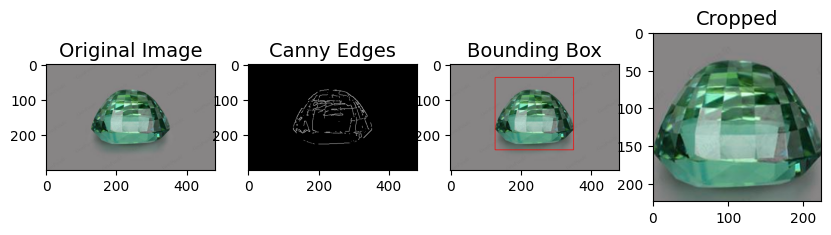

Processing Alexandrite...


100%|██████████| 1064/1064 [00:23<00:00, 44.54it/s]


Processing Amber...


100%|██████████| 112/112 [00:00<00:00, 300.49it/s]


Processing Amethyst...


 50%|████▉     | 995/2004 [00:23<00:23, 43.16it/s]

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



100%|██████████| 2004/2004 [00:34<00:00, 58.12it/s] 


Processing Ametrine...


100%|██████████| 633/633 [00:09<00:00, 63.93it/s] 


Processing Aquamarine...


 48%|████▊     | 1258/2648 [00:28<00:44, 31.31it/s]

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



 58%|█████▊    | 1534/2648 [00:37<00:42, 26.06it/s]

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



 58%|█████▊    | 1543/2648 [00:37<00:37, 29.23it/s]

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



 77%|███████▋  | 2044/2648 [00:53<00:21, 28.50it/s]

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



100%|██████████| 2648/2648 [01:09<00:00, 38.26it/s] 


Processing Blue Sapphire (Neelam)...


 24%|██▍       | 1416/5874 [00:45<02:28, 29.96it/s]

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



 47%|████▋     | 2735/5874 [01:27<01:27, 35.68it/s]

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



 73%|███████▎  | 4294/5874 [02:04<00:23, 67.31it/s]

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



100%|██████████| 5874/5874 [02:40<00:00, 36.64it/s] 


Processing Blue Topaz...


 50%|█████     | 689/1375 [00:19<00:05, 133.76it/s]

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



100%|██████████| 1375/1375 [00:32<00:00, 41.86it/s] 


Processing Blue Zircon...


100%|██████████| 449/449 [00:12<00:00, 36.82it/s] 


Processing Burmese Ruby...


 35%|███▍      | 405/1158 [00:11<00:20, 36.58it/s]

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



100%|██████████| 1158/1158 [00:32<00:00, 35.27it/s]


Processing Cats Eye...


 31%|███▏      | 574/1826 [00:16<00:34, 36.53it/s]

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



100%|██████████| 1826/1826 [00:31<00:00, 57.08it/s] 


Processing Citrine (Sunela)...


100%|██████████| 1620/1620 [00:40<00:00, 40.47it/s]


Processing Colombian Emerald...


 25%|██▌       | 296/1179 [00:07<00:21, 40.41it/s]

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



100%|██████████| 1179/1179 [00:28<00:00, 41.19it/s] 


Processing Cornflower Blue Sapphire...


100%|██████████| 40/40 [00:01<00:00, 38.21it/s]


Processing Emerald (Panna)...


 39%|███▊      | 3293/8516 [01:25<02:07, 41.01it/s]

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



 39%|███▉      | 3346/8516 [01:27<02:17, 37.65it/s]

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



 49%|████▊     | 4133/8516 [01:48<01:56, 37.76it/s]

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



 99%|█████████▉| 8419/8516 [03:20<00:02, 38.97it/s] 

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



 99%|█████████▉| 8429/8516 [03:21<00:02, 38.81it/s]

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



100%|██████████| 8516/8516 [03:23<00:00, 41.85it/s]


Processing Fire Opal...


100%|██████████| 390/390 [00:06<00:00, 56.93it/s] 


Processing Garnet...


 42%|████▏     | 695/1637 [00:17<00:19, 48.97it/s]

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



 49%|████▉     | 809/1637 [00:20<00:20, 40.17it/s]

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



100%|██████████| 1637/1637 [00:38<00:00, 41.99it/s] 


Processing Hessonite (Gomed)...


100%|██████████| 1849/1849 [00:40<00:00, 46.15it/s] 


Processing Iolite (Neeli)...


100%|██████████| 416/416 [00:10<00:00, 40.25it/s]


Processing Kashmir Blue Sapphire...


100%|██████████| 122/122 [00:03<00:00, 37.46it/s]


Processing Kyanite...


100%|██████████| 262/262 [00:01<00:00, 138.96it/s]


Processing Lapis Lazuli...


100%|██████████| 144/144 [00:04<00:00, 29.25it/s]


Processing Moldavite...


  2%|▏         | 19/1150 [00:00<00:06, 165.55it/s]

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



  7%|▋         | 81/1150 [00:00<00:05, 186.34it/s]

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



 10%|█         | 118/1150 [00:00<00:08, 117.97it/s]

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



 12%|█▏        | 133/1150 [00:00<00:08, 115.77it/s]

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



 15%|█▍        | 170/1150 [00:01<00:09, 98.33it/s] 

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



 16%|█▌        | 181/1150 [00:01<00:12, 76.63it/s]

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



 23%|██▎       | 267/1150 [00:02<00:10, 83.96it/s]

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



 28%|██▊       | 324/1150 [00:03<00:08, 101.55it/s]

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



 31%|███▏      | 362/1150 [00:03<00:07, 111.57it/s]

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



 36%|███▌      | 411/1150 [00:04<00:07, 105.43it/s]

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



 38%|███▊      | 435/1150 [00:04<00:06, 104.65it/s]

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



 42%|████▏     | 480/1150 [00:04<00:07, 94.61it/s] 

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



 44%|████▎     | 501/1150 [00:05<00:07, 91.21it/s]

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



 49%|████▉     | 565/1150 [00:05<00:05, 98.94it/s]

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



 60%|██████    | 690/1150 [00:07<00:04, 104.44it/s]

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



 66%|██████▌   | 757/1150 [00:07<00:04, 97.89it/s] 

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



 69%|██████▊   | 790/1150 [00:08<00:03, 99.47it/s]

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



 74%|███████▎  | 848/1150 [00:08<00:03, 100.37it/s]

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



 75%|███████▍  | 860/1150 [00:08<00:02, 103.90it/s]

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



 79%|███████▊  | 904/1150 [00:09<00:02, 103.01it/s]

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



 81%|████████▏ | 937/1150 [00:09<00:02, 97.57it/s] 

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



 87%|████████▋ | 1003/1150 [00:10<00:01, 88.67it/s]

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



 94%|█████████▍| 1082/1150 [00:11<00:00, 108.63it/s]

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



 98%|█████████▊| 1127/1150 [00:11<00:00, 100.12it/s]

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



100%|██████████| 1150/1150 [00:11<00:00, 97.08it/s] 


Processing Moonstone...


100%|██████████| 372/372 [00:09<00:00, 40.38it/s] 


Processing Navratna...


100%|██████████| 1/1 [00:00<00:00, 56.90it/s]


Processing No Oil Emerald...


100%|██████████| 5/5 [00:00<00:00, 24.92it/s]


OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

Processing Opal...


 26%|██▌       | 886/3397 [00:24<01:06, 37.50it/s]

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



 92%|█████████▏| 3133/3397 [00:58<00:07, 36.71it/s] 

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



 96%|█████████▌| 3262/3397 [01:02<00:03, 43.53it/s]

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



 96%|█████████▋| 3271/3397 [01:02<00:03, 36.87it/s]

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



100%|██████████| 3397/3397 [01:06<00:00, 51.32it/s]


Processing Padparadscha Sapphire...


100%|██████████| 16/16 [00:00<00:00, 28.61it/s]


Processing Panjshir Emerald...


100%|██████████| 17/17 [00:00<00:00, 32.55it/s]


Processing Paraiba Tourmaline...


100%|██████████| 17/17 [00:00<00:00, 30.74it/s]


Processing Pearl (Moti)...


100%|██████████| 144/144 [00:03<00:00, 47.97it/s]


Processing Peridot...


100%|██████████| 17/17 [00:00<00:00, 34.70it/s]


Processing Pigeon Blood Ruby...


100%|██████████| 14/14 [00:00<00:00, 31.00it/s]


Processing Pink Sapphire...


100%|██████████| 18/18 [00:00<00:00, 32.62it/s]


Processing Pitambari Neelam...


100%|██████████| 38/38 [00:00<00:00, 39.87it/s]


Processing Red Coral (Moonga)...


100%|██████████| 580/580 [00:15<00:00, 37.27it/s]


Processing Royal Blue Sapphire...


100%|██████████| 12/12 [00:00<00:00, 38.68it/s]


Processing Ruby (Manik)...


 46%|████▌     | 1014/2218 [00:29<00:35, 34.28it/s]

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



100%|██████████| 2218/2218 [00:58<00:00, 38.19it/s] 


Processing Spinel...


100%|██████████| 725/725 [00:17<00:00, 42.27it/s] 


Processing Star Ruby...


100%|██████████| 934/934 [00:12<00:00, 75.19it/s] 


Processing Tanzanite...


  8%|▊         | 34/411 [00:02<00:21, 17.75it/s]

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



100%|██████████| 411/411 [00:12<00:00, 32.56it/s]


Processing Tourmaline...


 15%|█▌        | 281/1844 [00:08<00:40, 39.01it/s]

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



 20%|██        | 375/1844 [00:11<00:39, 36.75it/s]

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



 23%|██▎       | 433/1844 [00:13<00:45, 31.04it/s]

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



 24%|██▍       | 443/1844 [00:13<00:44, 31.48it/s]

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



 25%|██▍       | 460/1844 [00:13<00:45, 30.74it/s]

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



100%|██████████| 1844/1844 [00:50<00:00, 36.31it/s]


Processing Turquoise...


100%|██████████| 2717/2717 [00:53<00:00, 51.02it/s] 


Processing White Coral...


100%|██████████| 323/323 [00:07<00:00, 40.78it/s] 


Processing White Sapphire...


100%|██████████| 245/245 [00:08<00:00, 29.83it/s]


Processing Yellow Sapphire - Pukhraj...


100%|██████████| 1040/1040 [00:30<00:00, 33.61it/s]


Processing Yellow Topaz...


 86%|████████▌ | 124/145 [00:03<00:00, 45.75it/s]

OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



100%|██████████| 145/145 [00:03<00:00, 37.14it/s]


Processing Zircon...


100%|██████████| 191/191 [00:07<00:00, 24.97it/s]


In [51]:
img_w, img_h = 224, 224

img = cv2.imread('../dat/images/Alexandrite/3.jpg')
show_cropped(img)

for gem in os.listdir('../dat/images'):
    out_folder = os.path.join('../dat/images_cropped/', gem)
    if not os.path.exists(out_folder):
        os.makedirs(out_folder)
    def process_image(img):
        image = cv2.imread(os.path.join('../dat/images/', gem, img))
        image = edge_and_cut(image)
        cv2.imwrite(os.path.join(out_folder, img), image)

    futures = [executor.submit(process_image, img) for img in os.listdir('../dat/images/' + gem)]
    print(f'Processing {gem}...')
    with tqdm(total=len(futures)) as pbar:
        for future in cf.as_completed(futures):
            future.result()
            pbar.update()

### Perform image augmentation

In [4]:
def transform_images(src, goal):
    for root, dirs, files in os.walk(src):
        dst = root.replace('images', 'images_augmented')
        os.makedirs(dst, exist_ok=True)
        
        flip = False
        size = len(files)
        num_to_edit = np.ceil((goal-size) / 3).astype(int)

        for file in np.random.choice(files, min(size, goal), replace=False):
            shutil.copy(os.path.join(root, file), os.path.join(dst, file))

        if num_to_edit > size:
            flip = True
            num_to_edit = np.ceil((goal-size) / 7).astype(int)
        print(root, max(0, min(num_to_edit, size)))


        for file in np.random.choice(files, max(0, min(num_to_edit, size)), replace=False):
            try:
                image = cv2.imread(os.path.join(root, file))
                if flip:
                    plt.imsave(os.path.join(dst, file[:-4]+'_flip'+file[-4:]), np.fliplr(image))
                    plt.imsave(os.path.join(dst, file[:-4]+'_flip'+file[-4:]), np.flipud(image))
                # apply different rotations
                for angle in rotations:
                    # save image
                    rot_img = transform.rotate(image, angle=angle)
                    plt.imsave(os.path.join(dst, file[:-4]+'_rot'+str(angle)+file[-4:]), rot_img)
                    if flip:
                        plt.imsave(os.path.join(dst, file[:-4]+'_'+str(angle)+'_fliplr'+file[-4:]), np.fliplr(rot_img))
                        plt.imsave(os.path.join(dst, file[:-4]+'_'+str(angle)+'_flipud'+file[-4:]), np.flipud(rot_img))
            except:
                pass

In [5]:
rotations = [90, 180, 270]
goal = 2000
transform_images(src='../dat/images_cropped/', goal=goal)

../dat/images_cropped/ 0
../dat/images_cropped/Alexandrite 312
../dat/images_cropped/Amber 112
../dat/images_cropped/Amethyst 0
../dat/images_cropped/Ametrine 456
../dat/images_cropped/Aquamarine 0
../dat/images_cropped/Blue Sapphire (Neelam) 0
../dat/images_cropped/Blue Topaz 209
../dat/images_cropped/Blue Zircon 222


In [67]:
import shutil

upper_bound = 2200
lower_bound = 1700

# delete all folders with less than 1700 images and remove images from the rest to have 2200 images
for root, dirs, files in os.walk('../dat/images_augmented_cropped/'):
    if root != '../dat/images_augmented_cropped/':
        if len(files) < lower_bound:
            shutil.rmtree(root)
        elif len(files) > upper_bound:
            for file in np.random.choice(files, len(files)-upper_bound, replace=False):
                os.remove(os.path.join(root, file))


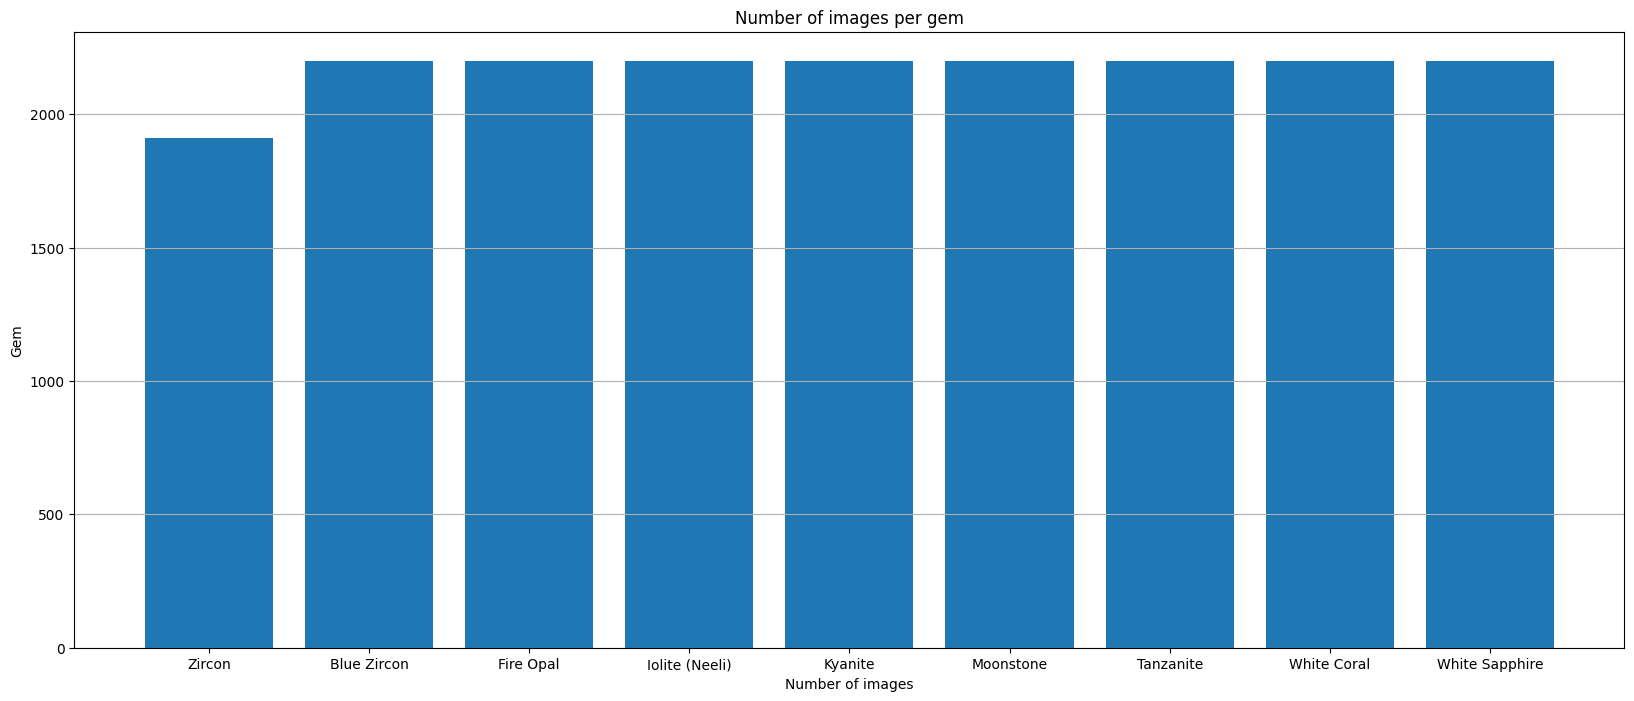

In [70]:
gem_count = []
for gem in os.listdir('../dat/images_augmented_cropped'):
    count = len(os.listdir('../dat/images_augmented_cropped/' + gem))
    gem_count += [{'gem': gem, 'count': count}]
gem_count = pd.DataFrame(gem_count)
gem_count.sort_values(by='count', ascending=True, inplace=True)
number_of_images = gem_count['count'].sum()

plt.figure(figsize=(20, 8))
plt.bar(gem_count['gem'], gem_count['count'])
plt.title('Number of images per gem')
plt.xlabel('Number of images')
plt.ylabel('Gem')
plt.grid(axis='y')
plt.show()
